# Setup Code

In [2]:
import seaborn as sns
import json

# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import plotly.io as pio

pio.renderers.default = "png"

# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [3]:
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML


import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

# We turn automatic differentiation off, to save GPU memory, as this notebook focuses on model inference not model training.
torch.set_grad_enabled(False)


## Helper and Visual Functions
def imshow(tensor, renderer=None, **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", **kwargs).show(renderer)

def line(tensor, renderer=None, **kwargs):
    px.line(y=utils.to_numpy(tensor), **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

/home/presi/miniconda3/envs/fv/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning:

Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.



# Prompt Experimenting

In [3]:
## Load the Models
model = HookedTransformer.from_pretrained(
    "gpt2-medium",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

Loaded pretrained model gpt2-medium into HookedTransformer


In [4]:
# Investigating when the model can perform ICL

#Examples
# example_prompt = "increase:decrease, good:bad, fast:"
# example_answer = "slow"
  
    
# example_prompt = "up:down, left:right, hot:"
# example_answer = "cold"

# example_prompt =   "fast:slow, good:bad, loud:"
# example_answer = "quiet"

example_prompt = "light:dark, warm:cold, alive:"
example_answer = "dead"

utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'light', ':', 'dark', ',', ' warm', ':', 'cold', ',', ' alive', ':']
Tokenized answer: [' dead']


Performance on answer token:
Rank: 135      Logit: 11.66 Prob:  0.03% Token: | dead|

Top 0th token. Logit: 19.44 Prob: 63.05% Token: |dead|
Top 1th token. Logit: 16.82 Prob:  4.62% Token: |aw|
Top 2th token. Logit: 16.59 Prob:  3.66% Token: |in|
Top 3th token. Logit: 16.48 Prob:  3.28% Token: |d|
Top 4th token. Logit: 15.59 Prob:  1.34% Token: |f|
Top 5th token. Logit: 15.49 Prob:  1.22% Token: |al|
Top 6th token. Logit: 15.32 Prob:  1.02% Token: |not|
Top 7th token. Logit: 15.15 Prob:  0.86% Token: |death|
Top 8th token. Logit: 15.09 Prob:  0.82% Token: |s|
Top 9th token. Logit: 14.92 Prob:  0.69% Token: |non|


Ranks of the answer tokens: [(' dead', 135)]

# Getting Dataset

In [ ]:
# Opening JSON file
f = open('antonym.json')
 
# returns JSON object 
examples = json.load(f)

# Iterate through Examples
dataset = []
for example in examples:
    dataset.append(example["input"]+':'+example["output"])

prompts = []
answers = []

# Split the dataset into prompts and answers with 2 examples per prompt
for i in range(0, len(dataset), 3):
    prompt = dataset[i]+','+dataset[i+1]+','+dataset[i+2].split(':')[0]+':'
    prompts.append(prompt)
    answers.append(dataset[i+2].split(':')[1])


# Getting prompts ready for study

In [4]:
#Prompt Generation

# List of prompts
prompts = [
    "increase:decrease, good:bad, fast:",
    "up:down, left:right, hot:",
    "fast:slow, good:bad, quiet:",
    "light:dark, warm:cold, dark:",
]
# List of answers, in the format (correct, incorrect)
answers = ["slow", "cold", "quiet", "light"]

# List of the token (ie an integer) corresponding to each answer, in the format (correct_token, incorrect_token)
answer_tokens = model.to_tokens(answers, prepend_bos=False)
tokens = model.to_tokens(prompts)

# Print the prompts, answers and tokens
print(prompts)
print(answers)
print(answer_tokens)


['increase:decrease, good:bad, fast:', 'up:down, left:right, hot:', 'fast:slow, good:bad, quiet:', 'light:dark, warm:cold, dark:']
['slow', 'cold', 'quiet', 'light']
tensor([[38246],
        [36673],
        [39624],
        [ 2971]], device='cuda:0')


# Convert Datset To Tokens

In [ ]:
prompts_tokens = model.to_tokens(prompts)
prompts_tokens = prompts_tokens.cuda()

answers_tokens = model.to_tokens(answers, prepend_bos=False).flatten()
answers_tokens = answers_tokens.cuda()


# Run the Model

In [ ]:
# Run the model and cache all activations
logits, cache = model.run_with_cache(prompts_tokens)

# Check Accuracy

In [ ]:
print((logits[:, -1, :].argmax(-1).item() == answers_tokens).mean())

# Initial Explorations

In [5]:
tokens = model.to_tokens(prompts, prepend_bos=True)
# Move the tokens to the GPU
tokens = tokens.cuda()
# Run the model and cache all activations
original_logits, cache = model.run_with_cache(tokens)

# Logit Lens

### Value of answer logit across different layers at last token pos

In [11]:
# Select which prompt
prompt_num = 0

In [13]:
answer_tokens.flatten()[0]

tensor(38246, device='cuda:0')

torch.Size([49, 4, 1024])


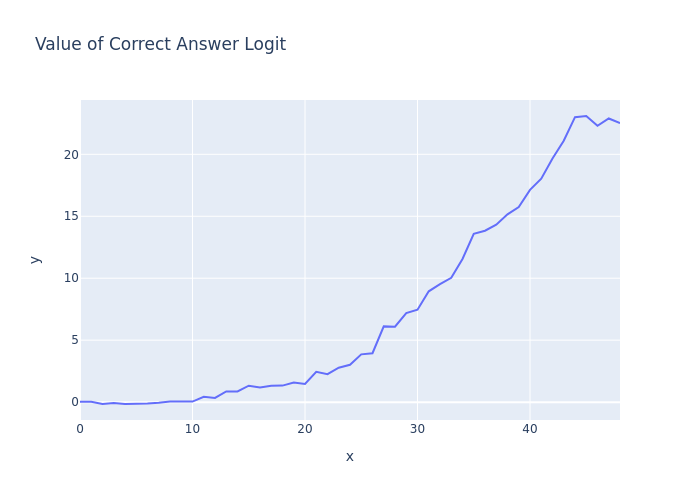

In [39]:
# Returns the accumulated residual stream at each layer/sub-layer and apply_ln applies final layer norm
accumulated_residual, labels = cache.accumulated_resid(
    layer=-1, incl_mid=True, pos_slice=-1, apply_ln=True, return_labels=True
)
print(accumulated_residual.shape)

#Project each layer residual at last token onto vocab space
projection_vocab = einsum("layer d_model, d_model d_vocab --> layer d_vocab", accumulated_residual[:,prompt_num,:], model.W_U)


line(
    projection_vocab[:,answer_tokens.flatten()[prompt_num]].flatten(),
    hover_name=labels,
    title="Value of Correct Answer Logit",
)


### Look at top 1 token of projected residual stream and associated logit value

torch.Size([25, 4, 14, 768])
torch.Size([25, 14, 50257])


<Axes: >

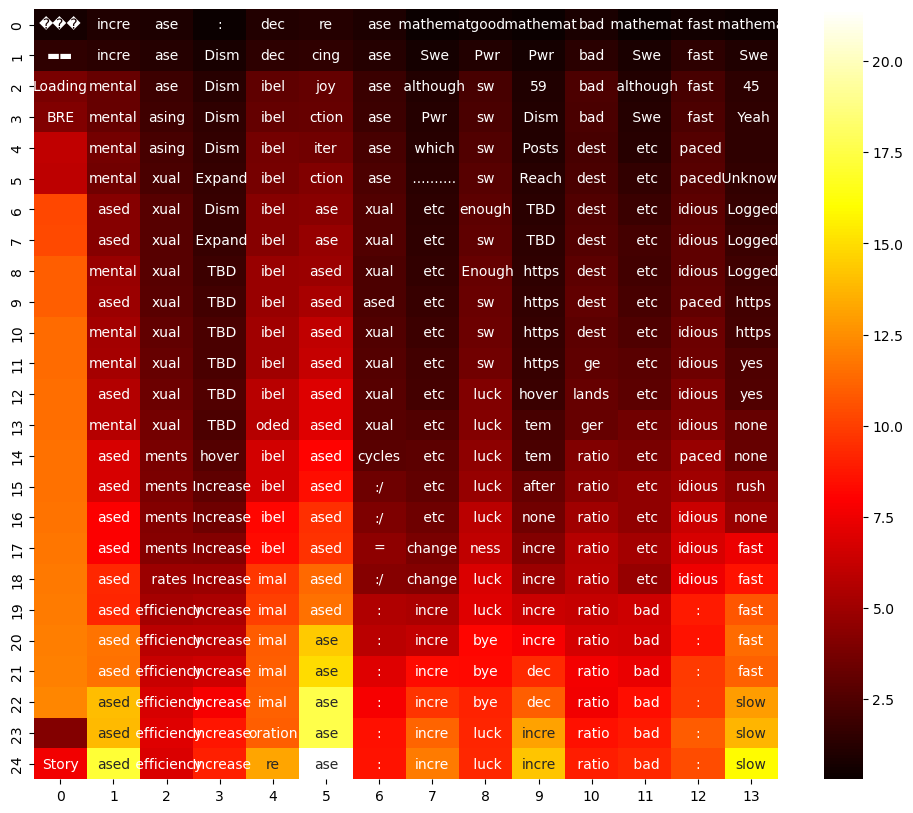

In [ ]:
from matplotlib import pyplot as plt
import numpy as np


# Returns the accumulated residual stream at each layer/sub-layer and apply_ln applies final layer norm
accumulated_residual, labels = cache.accumulated_resid(
    layer=-1, incl_mid=True, apply_ln=True, return_labels=True
)
print(accumulated_residual.shape)

# Project each layer and each position onto vocab space
projection_vocab = einsum("layer pos d_model, d_model d_vocab --> layer pos d_vocab", accumulated_residual[:,0,:,:], model.W_U)

print(projection_vocab.shape)

# Get maximum logit at each layer
max_logit, max_index = projection_vocab.max(-1)

# Convert max index tokens to strings
top_preds = [model.to_str_tokens(layer) for layer in max_index]

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(max_logit.cpu(), annot=top_preds, fmt = '', cmap='hot')

In [58]:
correct_dot = einsum("layer pos d_model, d_model --> layer pos", decomposed_residual[:,prompt_num,:,:], model.W_U[:, answer_tokens.flatten()[prompt_num]])
correct_dot.shape

torch.Size([50, 14])

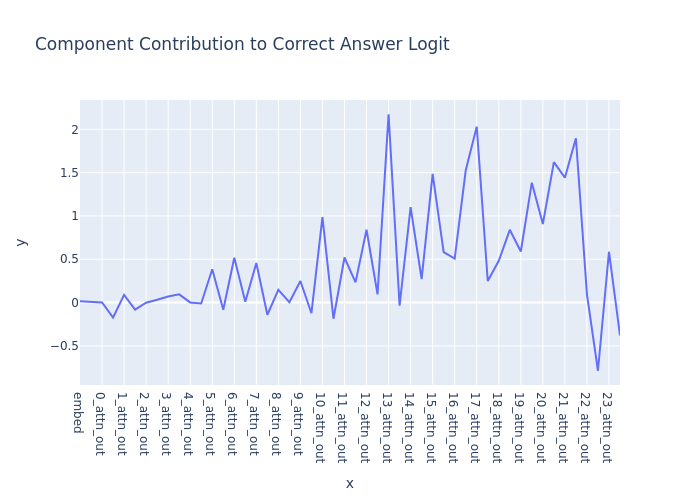

In [80]:
decomposed_residual, labels = cache.decompose_resid(
    layer=-1, apply_ln=True, return_labels=True
)

# Project each layer and each position onto vocab space
correct_dot = einsum("layer pos d_model, d_model --> layer pos", decomposed_residual[:,prompt_num,:,:], model.W_U[:, answer_tokens.flatten()[prompt_num]])


line(
    correct_dot[:, -1].flatten(),
    hover_name=labels,
    x=labels,
    title="Component Contribution to Correct Answer Logit",
)

# Get the specific components that contribute most

In [81]:
for i, x in enumerate(correct_dot[:,-1].topk(10).indices):
   print(i, labels[x], correct_dot[x,-1].item())

0 13_attn_out 2.1737051010131836
1 17_attn_out 2.030968427658081
2 21_mlp_out 1.8970786333084106
3 20_mlp_out 1.6212023496627808
4 16_mlp_out 1.5243083238601685
5 15_attn_out 1.4860551357269287
6 21_attn_out 1.4415091276168823
7 19_mlp_out 1.3836383819580078
8 14_attn_out 1.1006298065185547
9 10_attn_out 0.9858373403549194


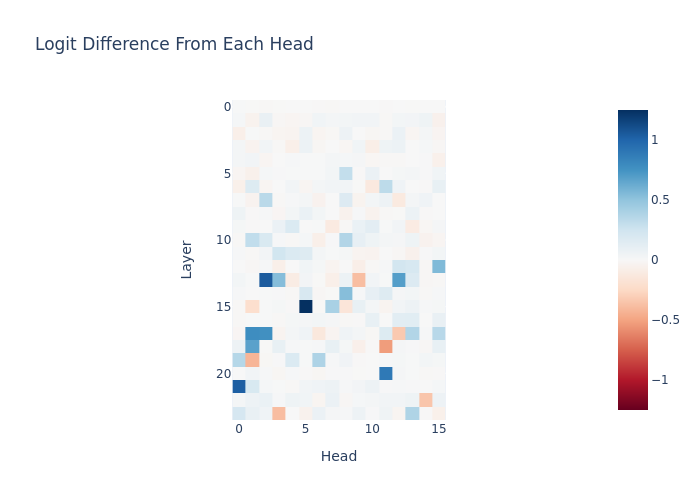

In [100]:
# Get head residuals
per_head_residual, labels = cache.stack_head_results(
    layer=-1, pos_slice=-1, apply_ln=True, return_labels=True
)

# Get the dot product of these with correct answer token
per_head_dot = einsum("head d_model, d_model -> head", per_head_residual[:,prompt_num,:], model.W_U[:,answer_tokens.flatten()[prompt_num]])

# Store top 10 heads
top_heads = per_head_dot.topk(10).indices

# Rearrange for plotting\
per_head_dot = einops.rearrange(
    per_head_dot,
    "(layer head_index) -> layer head_index",
    layer=model.cfg.n_layers,
    head_index=model.cfg.n_heads,
)
imshow(
    per_head_dot,
    labels={"x": "Head", "y": "Layer"},
    title="Logit Difference From Each Head",
)

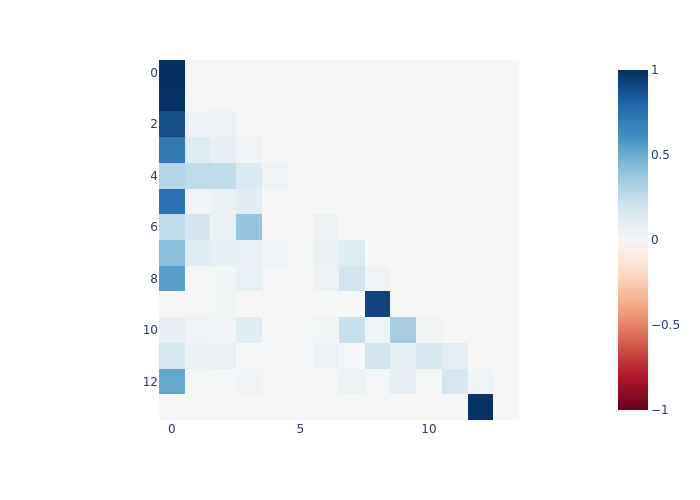

Layer 15, Head 5
['<|endoftext|>', 'incre', 'ase', ':', 'dec', 're', 'ase', ',', ' good', ':', 'bad', ',', ' fast', ':']


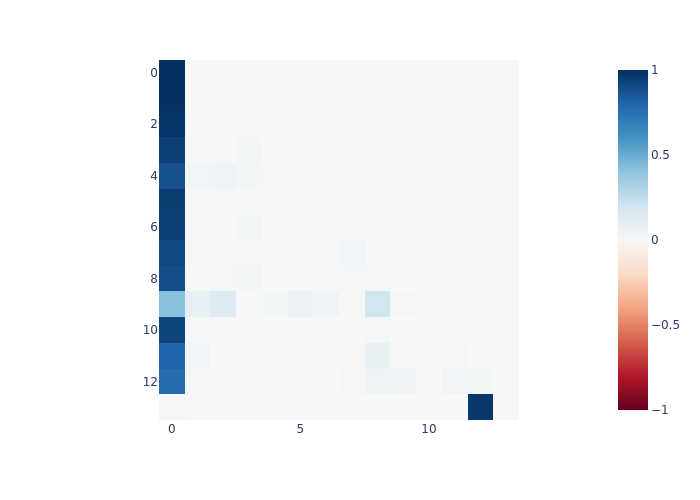

Layer 13, Head 2
['<|endoftext|>', 'incre', 'ase', ':', 'dec', 're', 'ase', ',', ' good', ':', 'bad', ',', ' fast', ':']


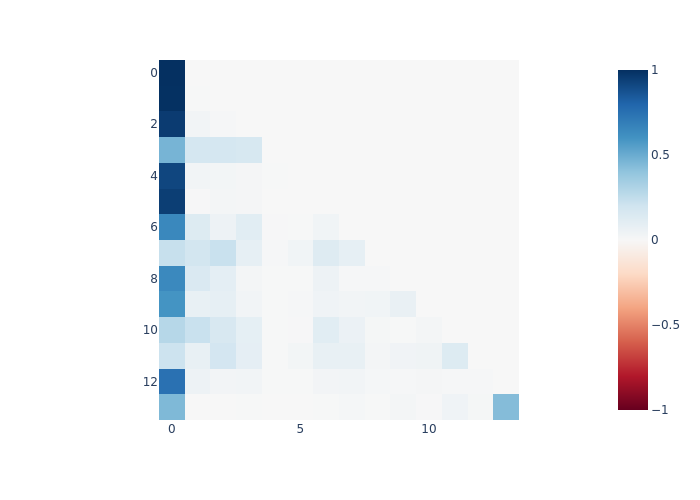

Layer 21, Head 0
['<|endoftext|>', 'incre', 'ase', ':', 'dec', 're', 'ase', ',', ' good', ':', 'bad', ',', ' fast', ':']


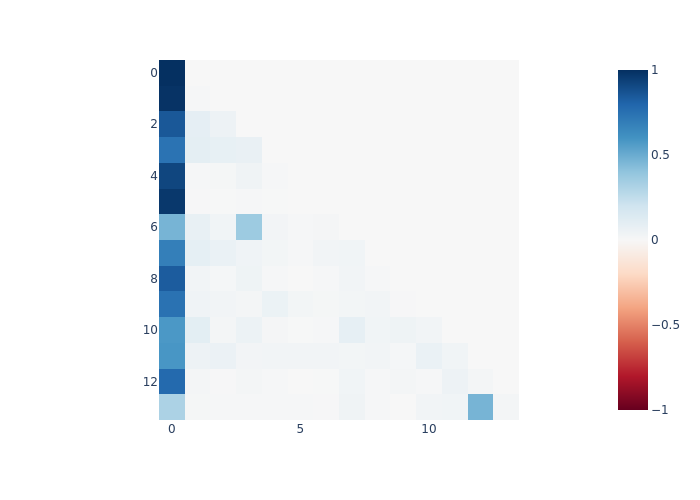

Layer 20, Head 11
['<|endoftext|>', 'incre', 'ase', ':', 'dec', 're', 'ase', ',', ' good', ':', 'bad', ',', ' fast', ':']


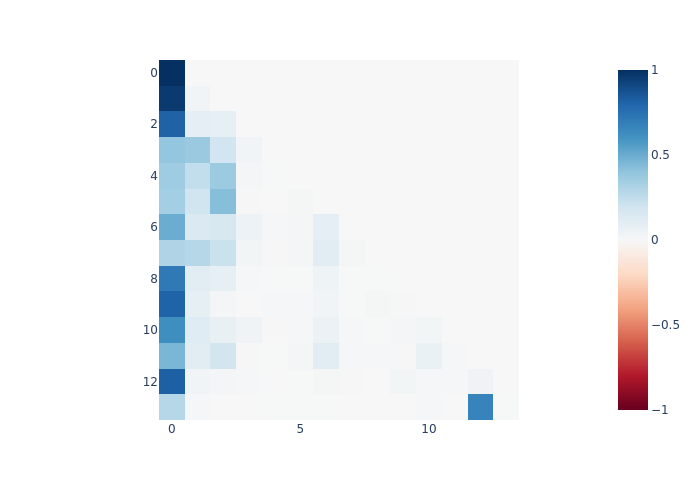

Layer 17, Head 1
['<|endoftext|>', 'incre', 'ase', ':', 'dec', 're', 'ase', ',', ' good', ':', 'bad', ',', ' fast', ':']


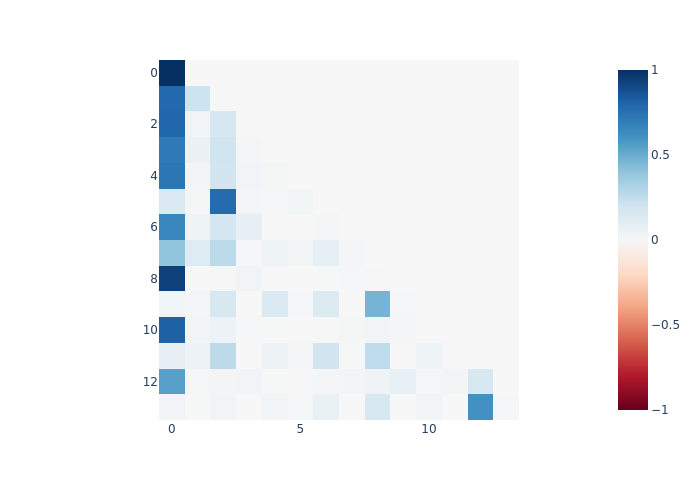

Layer 17, Head 2
['<|endoftext|>', 'incre', 'ase', ':', 'dec', 're', 'ase', ',', ' good', ':', 'bad', ',', ' fast', ':']


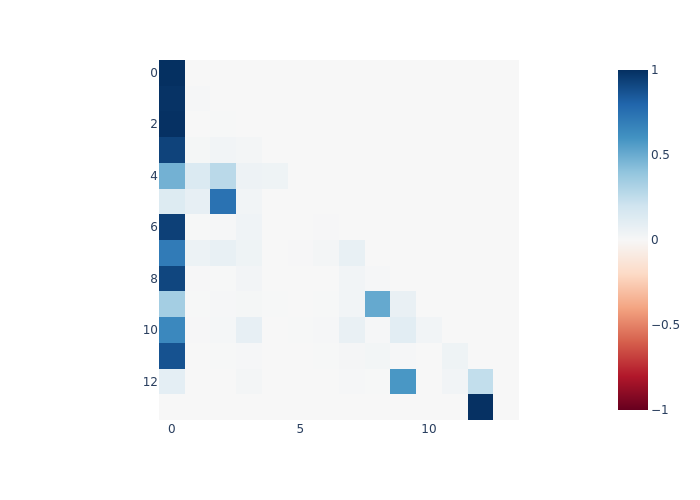

Layer 13, Head 12
['<|endoftext|>', 'incre', 'ase', ':', 'dec', 're', 'ase', ',', ' good', ':', 'bad', ',', ' fast', ':']


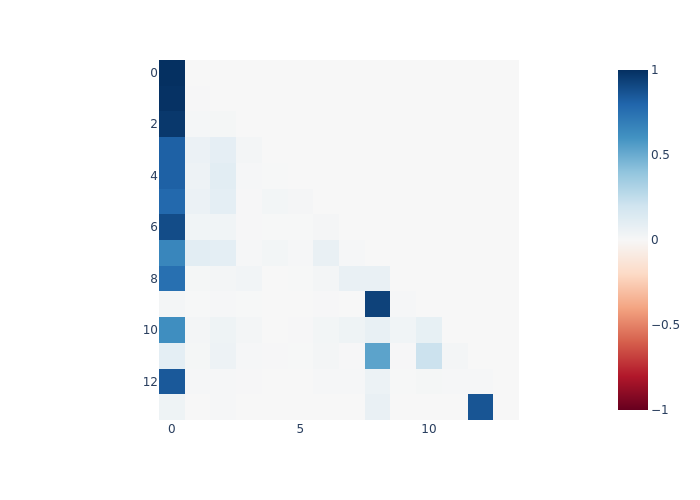

Layer 18, Head 1
['<|endoftext|>', 'incre', 'ase', ':', 'dec', 're', 'ase', ',', ' good', ':', 'bad', ',', ' fast', ':']


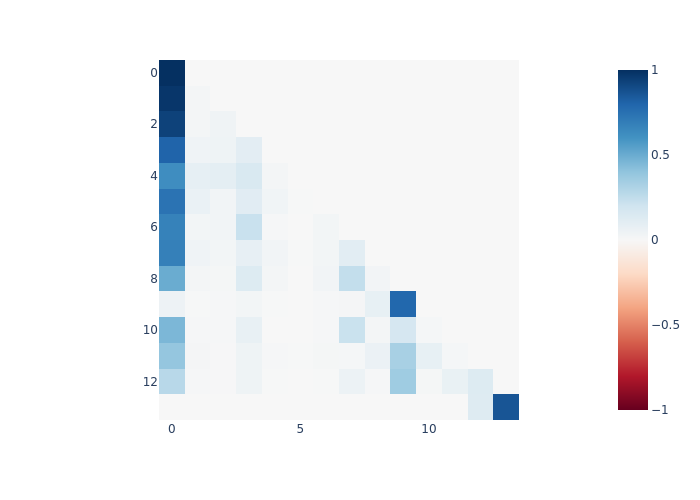

Layer 12, Head 15
['<|endoftext|>', 'incre', 'ase', ':', 'dec', 're', 'ase', ',', ' good', ':', 'bad', ',', ' fast', ':']


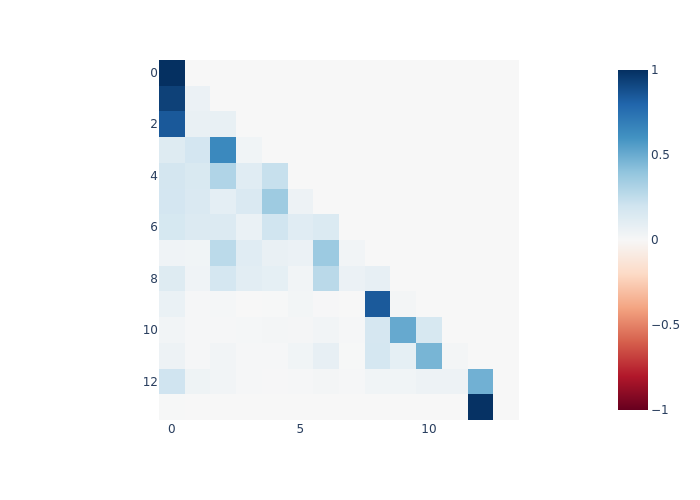

Layer 13, Head 3
['<|endoftext|>', 'incre', 'ase', ':', 'dec', 're', 'ase', ',', ' good', ':', 'bad', ',', ' fast', ':']


In [109]:
for i in range(10):
    layer = top_heads[i]//model.cfg.n_heads
    index = top_heads[i]%model.cfg.n_heads
    imshow(cache[f'blocks.{layer}.attn.hook_pattern'][prompt_num][index])
    labels={"x": "Head", "y": "Layer"}
    print(f"Layer {layer}, Head {index}")
    print(model.to_str_tokens(tokens[prompt_num]))

# Looking at the top MLPs

In [149]:
# Print the prompt
print(model.to_str_tokens(tokens[prompt_num]))

# Taken from figure
top_mlp_layers = [16, 20, 21]

# Iterate over top contributing MLP Layers
for layer in top_mlp_layers:
    # For each layer, get the top contributing neurons
    neuron_contr = einsum('d_mlp d_model, d_model -> d_mlp', model.blocks[layer].mlp.W_out.detach(), model.W_U[:,answer_tokens.flatten()[prompt_num]])
    top_neurons = neuron_contr.topk(10).indices

    # Project the top contributing neurons onto the vocab space
    projected_val = einsum('top d_model, d_model d_vocab-> top d_vocab', model.blocks[layer].mlp.W_out[top_neurons, :].detach(), model.W_U)

    print(f"__________{layer}__________")
    for x in range(10):
        # Print the vocab projection of the top contributing neurons
        print("Neuron: ", top_neurons[x].item(), "Contribution: ",neuron_contr[top_neurons[x]].item())
        print(model.to_str_tokens(projected_val[x, :].topk(10).indices))
              

['<|endoftext|>', 'incre', 'ase', ':', 'dec', 're', 'ase', ',', ' good', ':', 'bad', ',', ' fast', ':']
__________16__________
Neuron:  1643 Contribution:  3.348935842514038
[' inability', ' insufficient', 'failed', ' ineffective', ' failed', ' failures', ' unable', ' lackluster', ' lacks', ' lose']
Neuron:  591 Contribution:  2.997021436691284
['National', 'Ent', 'Strong', 'Individual', 'Member', 'Hall', 'Elect', 'Church', 'Trans', 'Tax']
Neuron:  2924 Contribution:  2.8960635662078857
[' negatively', 'appropriately', ' cautiously', ' differently', ' creatively', ' responsibly', ' objectively', ' wisely', ' positively', ' offensively']
Neuron:  486 Contribution:  2.8068737983703613
[' ardu', ' tedious', ' painstaking', ' costly', 'intensive', 'expensive', ' labor', 'cost', ' exhausting', 'requires']
Neuron:  3524 Contribution:  2.6780171394348145
['_', '@', 'kid', 'boss', 'Mex', 'Mc', 'oft', '1992', 'Dr', '1986']
Neuron:  3950 Contribution:  2.586076498031616
['prem', 'dec', 'positive

# Looking at Function Vectors Causal Impact

In [ ]:
# Zero shot prompt
prompt = "increase:"

# Retrieve Function Vectors
FV = np.load("Antonym_FV.npy", allow_pickle=True)

# Find the layer of most impact


In [ ]:
# 